In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# Import self-implemented torch dataset
from datasets import ESCDataset

## Now training and testing on ESC-10

In [2]:
train_data = ESCDataset(root='ESC-50-master', 
                        esc50=False, 
                        val_fold=4,
                        train=True,
                        download=True)
valid_data = ESCDataset(root='ESC-50-master', 
                        esc50=False, 
                        val_fold=4,
                        train=False,
                        download=False)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=16, shuffle=True)

print('train data length', len(train_data))
print('valid data length', len(valid_data))

print(train_data.data[0].shape)

Download not needed, files already on disk.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:04<00:00, 18.47it/s]

train data length 320
valid data length 80
(1, 128, 431)


In [3]:
from torchvision.models import resnet34
if torch.cuda.is_available():
  device=torch.device('cuda:0')
else:
  device=torch.device('cpu')
  
resnet_model = resnet34(pretrained=True)
resnet_model.fc = nn.Linear(512, train_data.num_classes)
resnet_model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet_model = resnet_model.to(device)

/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xiaofan/anaconda3/envs/esc50-py38/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [4]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, train_losses, valid_losses, change_lr=None):
  for epoch in tqdm(range(1,epochs+1)):
    model.train()
    batch_losses=[]
    if change_lr:
      optimizer = change_lr(optimizer, epoch)
    for i, data in enumerate(train_loader):
      x, y = data
      optimizer.zero_grad()
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      loss.backward()
      batch_losses.append(loss.item())
      optimizer.step()
    train_losses.append(batch_losses)
    print(f'Epoch - {epoch} Train-Loss : {np.mean(train_losses[-1])}')
    model.eval()
    batch_losses=[]
    trace_y = []
    trace_yhat = []
    for i, data in enumerate(valid_loader):
      x, y = data
      x = x.to(device, dtype=torch.float32)
      y = y.to(device, dtype=torch.long)
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      trace_y.append(y.cpu().detach().numpy())
      trace_yhat.append(y_hat.cpu().detach().numpy())      
      batch_losses.append(loss.item())
    valid_losses.append(batch_losses)
    trace_y = np.concatenate(trace_y)
    trace_yhat = np.concatenate(trace_yhat)
    accuracy = np.mean(trace_yhat.argmax(axis=1)==trace_y)
    print(f'Epoch - {epoch} Valid-Loss : {np.mean(valid_losses[-1])} Valid-Accuracy : {accuracy}')

In [5]:
def setlr(optimizer, lr):
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  return optimizer

learning_rate = 2e-4
optimizer = optim.Adam(resnet_model.parameters(), lr=learning_rate)
epochs = 25
loss_fn = nn.CrossEntropyLoss()
resnet_train_losses=[]
resnet_valid_losses=[]
def lr_decay(optimizer, epoch):
  if epoch%10==0:
    new_lr = learning_rate / (10**(epoch//10))
    optimizer = setlr(optimizer, new_lr)
    print(f'Changed learning rate to {new_lr}')
  return optimizer
train(resnet_model, loss_fn, train_loader, valid_loader, epochs, optimizer, resnet_train_losses, resnet_valid_losses, lr_decay)

  4%|██████▊                                                                                                                                                                  | 1/25 [00:01<00:47,  1.97s/it]

Epoch - 1 Train-Loss : 1.1745779454708098
Epoch - 1 Valid-Loss : 0.7681519210338592 Valid-Accuracy : 0.7375


  8%|█████████████▌                                                                                                                                                           | 2/25 [00:04<00:59,  2.59s/it]

Epoch - 2 Train-Loss : 0.5087611846625805
Epoch - 2 Valid-Loss : 0.4520606011152267 Valid-Accuracy : 0.875
Epoch - 3 Train-Loss : 0.35268231965601443


 12%|████████████████████▎                                                                                                                                                    | 3/25 [00:09<01:12,  3.30s/it]

Epoch - 3 Valid-Loss : 0.3295585185289383 Valid-Accuracy : 0.875
Epoch - 4 Train-Loss : 0.287231769785285


 16%|███████████████████████████                                                                                                                                              | 4/25 [00:10<00:53,  2.55s/it]

Epoch - 4 Valid-Loss : 0.3170214891433716 Valid-Accuracy : 0.8875
Epoch - 5 Train-Loss : 0.2274158681742847


 20%|█████████████████████████████████▊                                                                                                                                       | 5/25 [00:12<00:46,  2.31s/it]

Epoch - 5 Valid-Loss : 0.30886046290397645 Valid-Accuracy : 0.8875


 24%|████████████████████████████████████████▌                                                                                                                                | 6/25 [00:14<00:41,  2.19s/it]

Epoch - 6 Train-Loss : 0.20447182692587376
Epoch - 6 Valid-Loss : 0.2660079747438431 Valid-Accuracy : 0.9


 28%|███████████████████████████████████████████████▎                                                                                                                         | 7/25 [00:16<00:37,  2.09s/it]

Epoch - 7 Train-Loss : 0.24629228841513395
Epoch - 7 Valid-Loss : 0.5500308275222778 Valid-Accuracy : 0.85
Epoch - 8 Train-Loss : 0.1449983968399465


 32%|██████████████████████████████████████████████████████                                                                                                                   | 8/25 [00:17<00:31,  1.88s/it]

Epoch - 8 Valid-Loss : 0.27497317269444466 Valid-Accuracy : 0.9375
Epoch - 9 Train-Loss : 0.11374229332432151


 36%|████████████████████████████████████████████████████████████▊                                                                                                            | 9/25 [00:19<00:27,  1.75s/it]

Epoch - 9 Valid-Loss : 0.3867926772683859 Valid-Accuracy : 0.9
Changed learning rate to 2e-05


 40%|███████████████████████████████████████████████████████████████████▏                                                                                                    | 10/25 [00:21<00:28,  1.90s/it]

Epoch - 10 Train-Loss : 0.07337409742176533
Epoch - 10 Valid-Loss : 0.19627908244729042 Valid-Accuracy : 0.925


 44%|█████████████████████████████████████████████████████████████████████████▉                                                                                              | 11/25 [00:22<00:25,  1.79s/it]

Epoch - 11 Train-Loss : 0.05757276704534888
Epoch - 11 Valid-Loss : 0.17023102194070816 Valid-Accuracy : 0.95
Epoch - 12 Train-Loss : 0.0672019902151078


 48%|████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 12/25 [00:24<00:21,  1.68s/it]

Epoch - 12 Valid-Loss : 0.2091486144810915 Valid-Accuracy : 0.95
Epoch - 13 Train-Loss : 0.055882393708452584


 52%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                | 13/25 [00:26<00:20,  1.68s/it]

Epoch - 13 Valid-Loss : 0.22658596485853194 Valid-Accuracy : 0.925
Epoch - 14 Train-Loss : 0.018802574276924132


 56%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                          | 14/25 [00:27<00:18,  1.64s/it]

Epoch - 14 Valid-Loss : 0.18014066517353058 Valid-Accuracy : 0.925
Epoch - 15 Train-Loss : 0.015871520049404352


 60%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                   | 15/25 [00:33<00:27,  2.79s/it]

Epoch - 15 Valid-Loss : 0.1934060115367174 Valid-Accuracy : 0.925


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 16/25 [00:35<00:25,  2.81s/it]

Epoch - 16 Train-Loss : 0.014379454171285033
Epoch - 16 Valid-Loss : 0.1894158147275448 Valid-Accuracy : 0.9375
Epoch - 17 Train-Loss : 0.01637984864646569


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 17/25 [00:37<00:20,  2.55s/it]

Epoch - 17 Valid-Loss : 0.19797702692449093 Valid-Accuracy : 0.925
Epoch - 18 Train-Loss : 0.033602745225653055


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 18/25 [00:39<00:15,  2.28s/it]

Epoch - 18 Valid-Loss : 0.21564359311014414 Valid-Accuracy : 0.925
Epoch - 19 Train-Loss : 0.016080638929270207


 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 19/25 [00:41<00:12,  2.12s/it]

Epoch - 19 Valid-Loss : 0.13313720598816872 Valid-Accuracy : 0.95
Changed learning rate to 2e-06


 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 20/25 [00:42<00:09,  1.90s/it]

Epoch - 20 Train-Loss : 0.030594976898282767
Epoch - 20 Valid-Loss : 0.1573638316243887 Valid-Accuracy : 0.9375


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 21/25 [00:44<00:07,  1.99s/it]

Epoch - 21 Train-Loss : 0.01233942222315818
Epoch - 21 Valid-Loss : 0.1626219131052494 Valid-Accuracy : 0.95
Epoch - 22 Train-Loss : 0.03362451296998188


 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 22/25 [00:48<00:07,  2.51s/it]

Epoch - 22 Valid-Loss : 0.16021397113800048 Valid-Accuracy : 0.95
Epoch - 23 Train-Loss : 0.020741038559935986


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 23/25 [00:51<00:04,  2.49s/it]

Epoch - 23 Valid-Loss : 0.15659744739532472 Valid-Accuracy : 0.95
Epoch - 24 Train-Loss : 0.023997116833925247


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 24/25 [00:52<00:02,  2.25s/it]

Epoch - 24 Valid-Loss : 0.16199914924800396 Valid-Accuracy : 0.95


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:53<00:00,  2.15s/it]

Epoch - 25 Train-Loss : 0.01550605088705197
Epoch - 25 Valid-Loss : 0.17779419645667077 Valid-Accuracy : 0.95


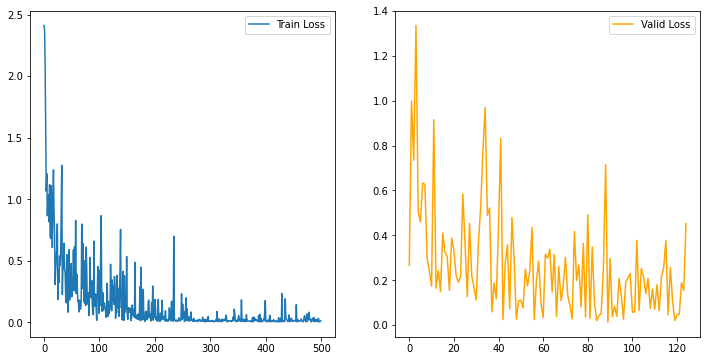

In [6]:
tl = np.asarray(resnet_train_losses).ravel()
vl = np.asarray(resnet_valid_losses).ravel()
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tl)
plt.legend(['Train Loss'])
plt.subplot(1,2,2)
plt.plot(vl,'orange')
plt.legend(['Valid Loss'])


## Visualization to help understanding

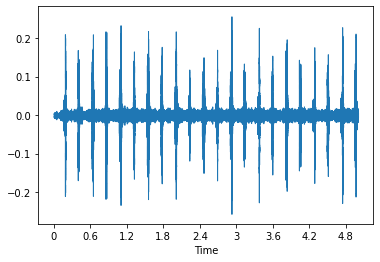

In [7]:
import librosa
import librosa.display
valid = valid_data.df
filename = valid[valid['category']=='clock_tick'].iloc[0]['filename']
wav, sr = librosa.load('ESC-50-master/audio/'+filename, sr=None)
librosa.display.waveshow(wav, sr=sr)

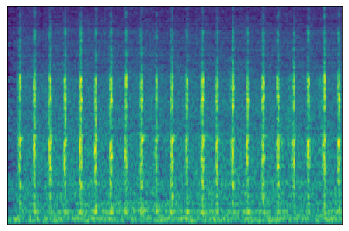

In [8]:
from datasets import spec_to_image, get_melspectrogram_db
librosa.display.specshow(spec_to_image(get_melspectrogram_db('ESC-50-master/audio/'+filename, sr)), cmap='viridis')